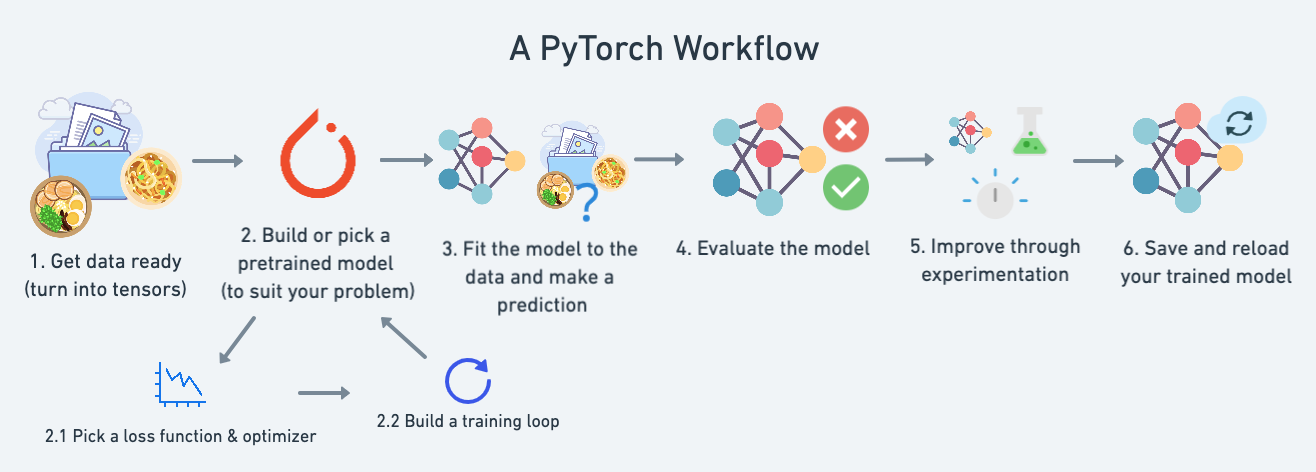

## Data

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [ ]:
print(f"First 5 X featues:\n{X[:5]}")
print(f"First 5 y labels:\n{y[:5]}")

In [ ]:
# Make dataframe
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label":y })
circles.head(10)

In [ ]:
circles.label.value_counts()

In [ ]:
# Visualize the plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           cmap=plt.cm.RdYlBu)

In [ ]:
# What shapes are my input and output ?
X.shape, y.shape

In [ ]:
# View the first example
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

In [ ]:
## Turn data into tensor
## otherwise it will cause problem for computation

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

In [ ]:
# lets split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

## Build a model

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
# 1. Construct a model class thta subclasses nn.Module

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        print(self.layer2(self.layer1(x)))
        return self.layer2(self.layer1(x))
    
    
model0 = CircleModel().to(device)
model0

This input features produces 5 output features and this is know as 5 hidden units or neurons

In [ ]:
## you can use nn.sequentional to perform forward computation of the input data through layers in the order they appear

model0 = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
).to(device)

model0

In [ ]:
# make predictions with the model
untrained_preds = model0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create optimizer
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Train

In [ ]:
# View the first five outputs of the forward pass on the test data
y_logits = model0(X_test.to(device))[:5]
y_logits

Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.

Which implements two layers of nn.Linear() which internally calls the following equation: `y = x⋅WeightsT+bias`

In [ ]:
y_preds_prob = torch.sigmoid(y_logits)
y_preds_prob

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_preds_prob)

# In full
y_preds_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

In [ ]:
y_test[:5]

### Building a training and testing loop

In [ ]:
torch.manual_seed(42)

# set epoch number
epochs = 100

# put the data to target device
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    
    #### Training
    model0.train()
    
    ## Forward pass (model outputs raw logits)
    y_logits = model0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    ## 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred = y_preds)
    
    ## 3. Optimizer
    optimizer.zero_grad()
    
    ## 4. loss backwards
    loss.backward()
    
    ## 5. optimizer step
    optimizer.step()
    
    ### Testing
    model0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true= y_test, y_pred = test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss:{loss:.5f} | Accuracy:{acc:.2f}% | Test loss:{test_loss:.5f} | Test acc:{test_acc:.2f}% " )

## Make predictions and evaluate the model

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model0, X_test, y_test)

In [ ]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
            
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model1 = CircleModel().to(device)
model1

In [ ]:
# Create a loss and optimizer
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create optimizer
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

# set epoch number
epochs = 1000

# put the data to target device
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    
    #### Training
    model0.train()
    
    ## Forward pass (model outputs raw logits)
    y_logits = model1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    ## 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true= y_test,y_pred = test_pred)
    
    ## 3. Optimizer
    optimizer.zero_grad()
    
    ## 4. loss backwards
    loss.backward()
    
    ## 5. optimizer step
    optimizer.step()
    
    ### Testing
    model0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true= y_test,y_pred = test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss:{loss:.5f} | Accuracy:{acc:.2f}% | Test loss:{test_loss:.5f} | Test acc:{test_acc:.2f}% " )

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model1, X_test, y_test)

**The missing piece: non-linearity**

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

How?

Let's find out.

## Building a model with non-linearity

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=50)
        self.layer_4 = nn.Linear(in_features=50, out_features=1)
        self.relu = nn.ReLU()
            
    def forward(self, x):
        return self.layer_4(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))

model_3 = CircleModel().to(device)
model_3

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calcuate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                 y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

### Evaluate 

In [ ]:
# make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

## Multi-class classification data

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [ ]:
model_4(X_blob_train.to(device))[:5]

In [ ]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

In [ ]:
y_logits = model_4(X_blob_test.to(device))

y_preds_prob = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_preds_prob[:5])

In [ ]:
torch.sum(y_preds_prob[0])

In [ ]:
print(y_preds_prob[0])
print(torch.argmax(y_preds_prob[0]))

### Training and testing loop for multiclass pyTorch Model


In [ ]:

# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
          # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

In [ ]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10]

In [ ]:
y_preds_prob = torch.softmax(y_logits, dim=1)

y_preds = y_preds_prob.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## Exercise

In [1]:
!nvidia-smi

Wed Apr 19 21:04:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.66       Driver Version: 517.66       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P1000       WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8    N/A /  N/A |      0MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device   

'cpu'

# Make a binary classification dataset with Scikit-Learn's make_moons() function

In [67]:
from sklearn import datasets

n_samples=1000
RANDOM_SEED=42

X, y = datasets.make_moons(n_samples=n_samples, 
                           noise=0.07, 
                           random_state=random_seed)
X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64))

In [68]:
# Turn data into a DataFrame
import pandas as pd
data_df = pd.DataFrame({"X0": X[:, 0],
                        "X1": X[:, 1],
                        "y": y})
data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


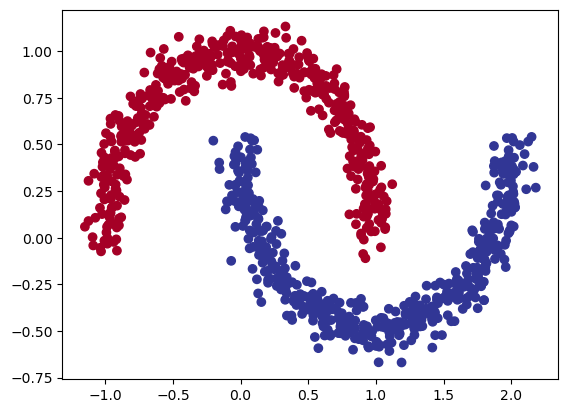

In [69]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [70]:
# Turn data into tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [71]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=in_features, 
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, 
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [72]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.0238, -0.0822],
                      [ 0.4423, -0.0654],
                      [ 0.4435,  0.5112],
                      [-0.6139,  0.2721],
                      [ 0.1335,  0.1520],
                      [ 0.1032,  0.1934],
                      [-0.3402, -0.0905],
                      [ 0.6718,  0.4751],
                      [-0.0266, -0.6651],
                      [ 0.0310, -0.4815]])),
             ('layer1.bias',
              tensor([ 0.5750, -0.4293, -0.0511, -0.1569,  0.1258,  0.6654,  0.0672,  0.4095,
                       0.5489,  0.5709])),
             ('layer2.weight',
              tensor([[-0.1092, -0.0707,  0.1524, -0.0863,  0.1481, -0.0691, -0.2145,  0.1287,
                        0.0485,  0.1410],
                      [ 0.3142,  0.2159,  0.2998,  0.0169, -0.2720, -0.2218, -0.1964, -0.2787,
                       -0.1585, -0.2911],
                      [-0.2918, -0.1890, -0.3117, -0.1941,  0.1206,  0.2638

# Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [73]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

- To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
- Train the model for long enough for it to reach over 96% accuracy.
- The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [74]:
print("Logits:")
print(model_0(X_train.to(device)[:10]).squeeze())

# prediction probabilities
print("pred prob")
print(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze()))

# prediction probabilities
print("pred labels")
print(torch.round(torch.sigmoid(model_0(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([-0.1449, -0.3503, -0.2658, -0.2655, -0.2894, -0.2786, -0.2838, -0.2925,
        -0.2119, -0.3366], grad_fn=<SqueezeBackward0>)
pred prob
tensor([0.4638, 0.4133, 0.4339, 0.4340, 0.4281, 0.4308, 0.4295, 0.4274, 0.4472,
        0.4166], grad_fn=<SigmoidBackward0>)
pred labels
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<RoundBackward0>)


# Training the model

In [75]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [76]:
torch.manual_seed(random_seed)

epochs=1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    # print(y_logits[:5]) # model raw outputs are "logits"
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_probs)

    # 2. Calculaute the loss
    loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
    acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
    loss.backward()

    # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
    optimizer.step()

    ### Testing
    model_0.eval() 
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate the loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int()) 

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")
     

Epoch: 0 | Loss: 0.69 Acc: 0.50 | Test loss: 0.69 Test acc: 0.50
Epoch: 100 | Loss: 0.33 Acc: 0.85 | Test loss: 0.35 Test acc: 0.87
Epoch: 200 | Loss: 0.23 Acc: 0.89 | Test loss: 0.23 Test acc: 0.89
Epoch: 300 | Loss: 0.22 Acc: 0.90 | Test loss: 0.22 Test acc: 0.89
Epoch: 400 | Loss: 0.21 Acc: 0.90 | Test loss: 0.21 Test acc: 0.89
Epoch: 500 | Loss: 0.21 Acc: 0.91 | Test loss: 0.21 Test acc: 0.89
Epoch: 600 | Loss: 0.20 Acc: 0.91 | Test loss: 0.21 Test acc: 0.89
Epoch: 700 | Loss: 0.20 Acc: 0.91 | Test loss: 0.20 Test acc: 0.89
Epoch: 800 | Loss: 0.19 Acc: 0.91 | Test loss: 0.20 Test acc: 0.89
Epoch: 900 | Loss: 0.18 Acc: 0.92 | Test loss: 0.18 Test acc: 0.90


# Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [77]:
# Plot the model predictions

import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

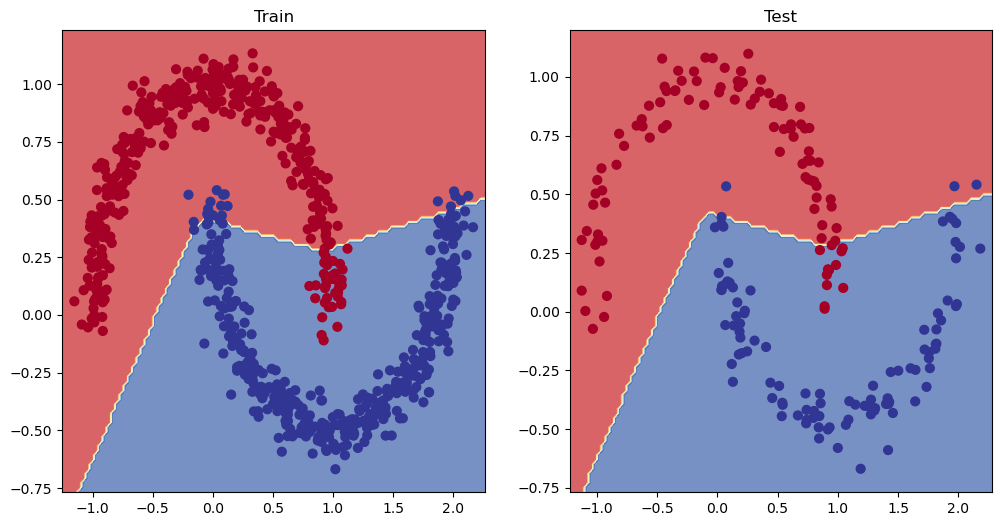

In [78]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

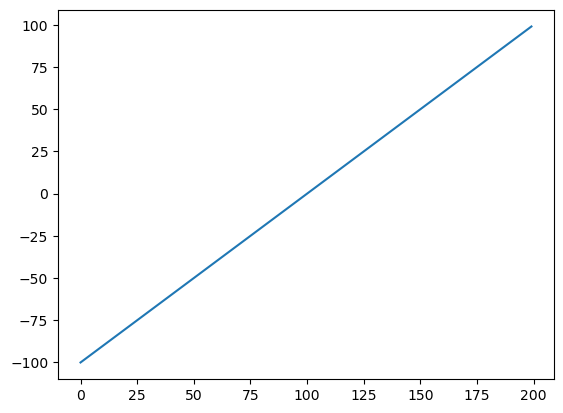

In [79]:
## Replicate tanh

tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

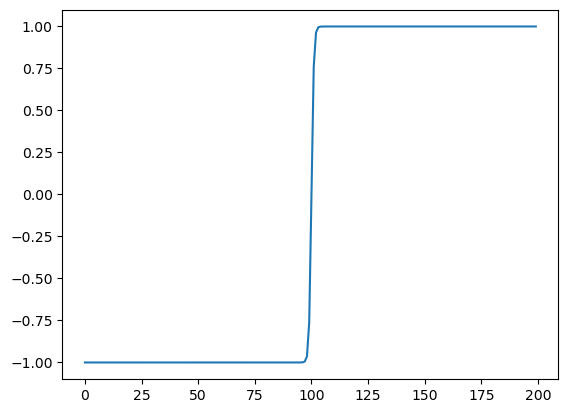

In [80]:
plt.plot(torch.tanh(tensor_A))

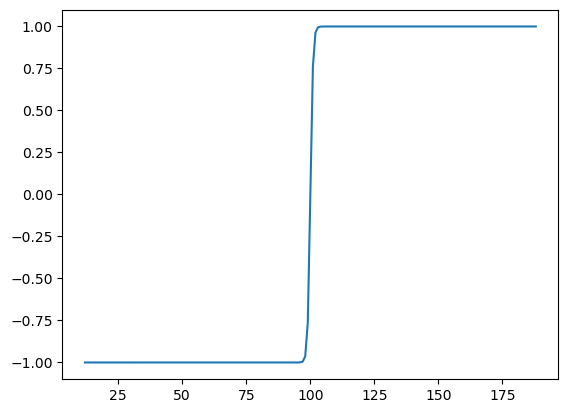

In [81]:
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))

# Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
- Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
- Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
- Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
- Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
- Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

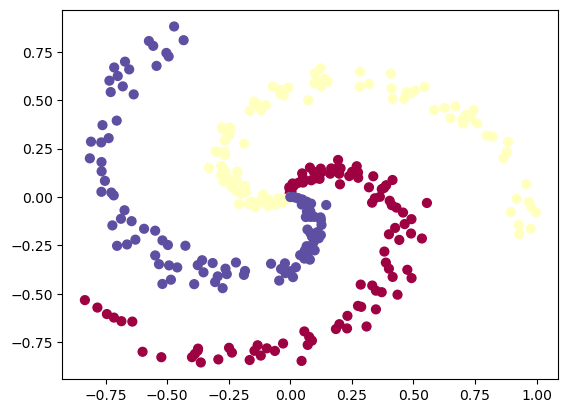

In [82]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [83]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [84]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [85]:

# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module): 
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=10)
        self.linear2 = nn.Linear(in_features=10, out_features=10)
        self.linear3 = nn.Linear(in_features=10, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [86]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2157, -0.0597,  0.2260],
        [-0.2024, -0.0527,  0.2268],
        [-0.2227, -0.0607,  0.2384],
        [-0.2192, -0.0557,  0.2876],
        [-0.2207, -0.0528,  0.2796],
        [-0.2192, -0.0564,  0.2454],
        [-0.2215, -0.0582,  0.2442],
        [-0.2260, -0.0633,  0.2367],
        [-0.2043, -0.0534,  0.2271],
        [-0.2176, -0.0522,  0.2930]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2685, 0.3138, 0.4176],
        [0.2705, 0.3141, 0.4154],
        [0.2658, 0.3126, 0.4216],
        [0.2606, 0.3069, 0.4325],
        [0.2610, 0.3087, 0.4304],
        [0.2654, 0.3123, 0.4223],
        [0.2652, 0.3123, 0.4225],
        [0.2656, 0.3125, 0.4219],
        [0.2701, 0.3141, 0.4158],
        [0.2600, 0.3068, 0.4332]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [87]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

In [88]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
    ## Training
    model_1.train()
    # 1. forward pass
    y_logits = model_1(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)
  
    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimizer step step step
    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Caculate loss and acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")
     

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.11 Test acc: 0.37
Epoch: 100 | Loss: 0.46 Acc: 0.77 | Test loss: 0.58 Test acc: 0.65
Epoch: 200 | Loss: 0.19 Acc: 0.94 | Test loss: 0.21 Test acc: 0.95
Epoch: 300 | Loss: 0.11 Acc: 0.96 | Test loss: 0.14 Test acc: 0.95
Epoch: 400 | Loss: 0.08 Acc: 0.98 | Test loss: 0.13 Test acc: 0.97
Epoch: 500 | Loss: 0.06 Acc: 0.97 | Test loss: 0.14 Test acc: 0.95
Epoch: 600 | Loss: 0.05 Acc: 0.98 | Test loss: 0.32 Test acc: 0.95
Epoch: 700 | Loss: 0.05 Acc: 0.98 | Test loss: 0.51 Test acc: 0.95
Epoch: 800 | Loss: 0.05 Acc: 0.98 | Test loss: 0.69 Test acc: 0.95
Epoch: 900 | Loss: 0.05 Acc: 0.98 | Test loss: 0.82 Test acc: 0.95


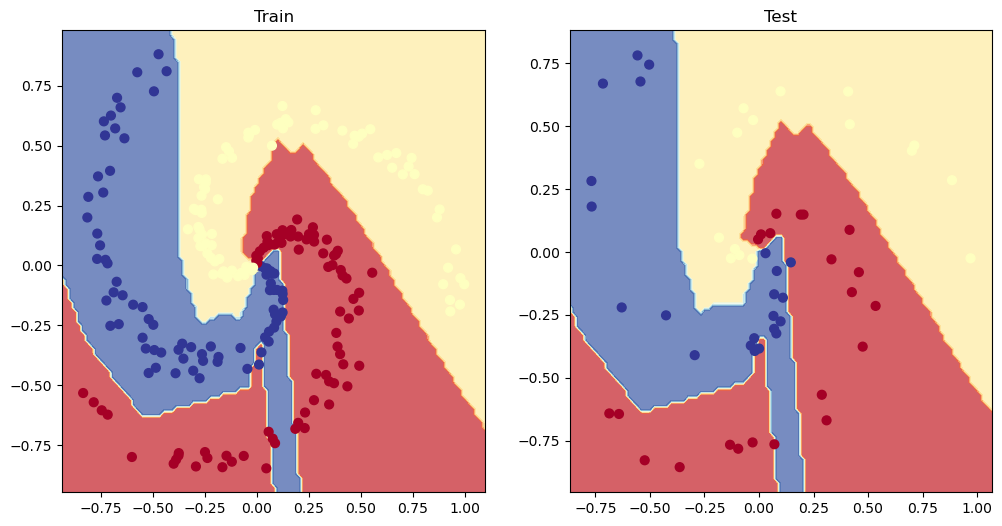

In [89]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [109]:
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
print(x, y)
print(xv)
print(yv)

[0.  0.5 1. ] [0. 1.]
[[0.  0.5 1. ]
 [0.  0.5 1. ]]
[[0. 0. 0.]
 [1. 1. 1.]]


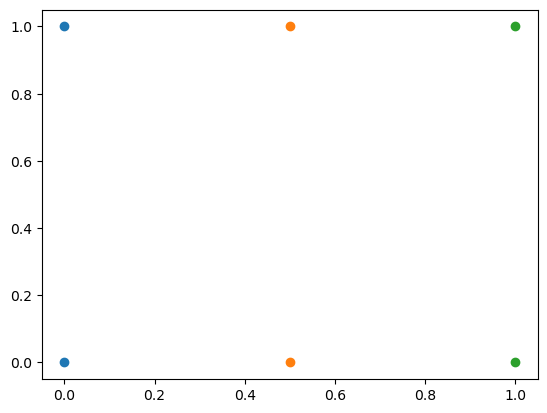

In [105]:
import matplotlib.pyplot as plt
plt.plot(xv, yv, marker='o', linestyle='none')